# Filtering Goodreads Reviews

During data exploration, a number of issues with the reviews have come to the surface that require some form of data *cleaning*, i.e. *selection* and *normalization* of reviews.

This notebook shows the cleaning steps that were taken.

### Non-Reviews

A plot of the review length distribution revealed that there are a few lengths (in number of characters) with high peaks in the frequency distribution. E.g. there are many more reviews of length 3 than expected given the rest of the distribution. Inspection revealed that many of those 3-character reviews contain only a rating, like '3.5' or '4.5'.

Another peak occurs at length 40: there is a large number of reviews that are only a URL for a webpage that contains the actual review. Goodreads shortens longer URLs to 40 characters in the anchor text of an HTML `<a>` element for display, with the full URL in the anchor `href` attribute. There are 30,277 such reviews. 

Types of non-reviews:

- length 0: these are empty reviews, which are no reviews at all. There is no review content.
- length 3: these are mainly reviews that only mention a rating, like '3.5' or '4.5'. 
- length 9-12: these are mainly reviews that only mention a rating followed by the word 'stars', like '3.5 stars' or '4.5 stars'.
- length 40: there is a large number of reviews that are only a URL for a webpage that contains the actual review. Goodreads shortens longer URLs to 40 characters in the anchor text of an HTML `<a>` element for display, with the full URL in the anchor `href` attribute. There are 30,277 such reviews. 



The steps below are taken with the aim to remove these so-called *non-reviews*:

In [1]:
# This reload library is just used for developing the REPUBLIC hOCR parser 
# and can be removed once this module is stable.
%reload_ext autoreload
%autoreload 2

# This is needed to add the repo dir to the path so jupyter
# can load the modules in the scripts directory from the notebooks
import os
import sys
repo_dir = os.path.split(os.getcwd())[0]
print(repo_dir)
if repo_dir not in sys.path:
    sys.path.append(repo_dir)
    
import numpy as np
import pandas as pd
import json
import csv
from collections import Counter
import gzip
import os

data_dir = '/Volumes/Samsung_T5/Data/Book-Reviews/GoodReads/'

author_file = os.path.join(data_dir, 'goodreads_book_authors.csv.gz') # author information
book_file = os.path.join(data_dir, 'goodreads_books.csv.gz') # basic book metadata
genre_file = os.path.join(data_dir, 'goodreads_book_genres_initial.csv.gz') # book genre information
review_file = os.path.join(data_dir, 'goodreads_reviews_dedup-no_text.csv.gz') # excludes text to save memory
review_text_file = os.path.join(data_dir, 'goodreads_reviews_dedup.csv.gz') # includes text



/Users/marijnkoolen/Code/Huygens/scale


In [2]:
review_df = pd.read_csv(review_file, sep='\t', compression='gzip')

review_df


,user_id,book_id,review_id,rating,date_added,date_updated,read_at,started_at,n_votes,n_comments,review_length
0,8842281e1d1347389f2ab93d60773d4d,24375664,5cd416f3efc3f944fce4ce2db2290d5e,5,Fri Aug 25 13:55:02 -0700 2017,Mon Oct 09 08:55:59 -0700 2017,Sat Oct 07 00:00:00 -0700 2017,Sat Aug 26 00:00:00 -0700 2017,16,0,968
1,8842281e1d1347389f2ab93d60773d4d,18245960,dfdbb7b0eb5a7e4c26d59a937e2e5feb,5,Sun Jul 30 07:44:10 -0700 2017,Wed Aug 30 00:00:26 -0700 2017,Sat Aug 26 12:05:52 -0700 2017,Tue Aug 15 13:23:18 -0700 2017,28,1,2086
2,8842281e1d1347389f2ab93d60773d4d,6392944,5e212a62bced17b4dbe41150e5bb9037,3,Mon Jul 24 02:48:17 -0700 2017,Sun Jul 30 09:28:03 -0700 2017,Tue Jul 25 00:00:00 -0700 2017,Mon Jul 24 00:00:00 -0700 2017,6,0,474
3,8842281e1d1347389f2ab93d60773d4d,22078596,fdd13cad0695656be99828cd75d6eb73,4,Mon Jul 24 02:33:09 -0700 2017,Sun Jul 30 10:23:54 -0700 2017,Sun Jul 30 15:42:05 -0700 2017,Tue Jul 25 00:00:00 -0700 2017,22,4,962
4,8842281e1d1347389f2ab93d60773d4d,6644782,bd0df91c9d918c0e433b9ab3a9a5c451,4,Mon Jul 24 02:28:14 -0700 2017,Thu Aug 24 00:07:20 -0700 2017,Sat Aug 05 00:00:00 -0700 2017,Sun Jul 30 00:00:00 -0700 2017,8,0,420
...,...,...,...,...,...,...,...,...,...,...,...
15739962,d0f6d1a4edcab80a6010cfcfeda4999f,1656001,b3d9a00405f7e96752d67b85deda4c7d,4,Mon Jun 04 18:08:44 -0700 2012,Tue Jun 26 18:58:46 -0700 2012,NaN,Sun Jun 10 00:00:00 -0700 2012,0,1,299
15739963,594c86711bd7acdaf655d102df52a9cb,10024429,2bcba3579aa1d728e664de293e16aacf,5,Fri Aug 01 18:46:18 -0700 2014,Fri Aug 01 18:47:07 -0700 2014,NaN,NaN,0,0,71
15739964,594c86711bd7acdaf655d102df52a9cb,6721437,7c1a7fcc2614a1a2a29213c11c991083,3,Tue Aug 27 12:49:25 -0700 2013,Tue Aug 27 12:53:46 -0700 2013,NaN,NaN,0,0,224
15739965,594c86711bd7acdaf655d102df52a9cb,15788197,74a9f9d1db09a90aae3a5acea68c6593,2,Fri May 03 13:06:15 -0700 2013,Fri May 03 15:35:39 -0700 2013,Fri May 03 15:35:39 -0700 2013,Fri May 03 00:00:00 -0700 2013,0,0,108


<AxesSubplot:>

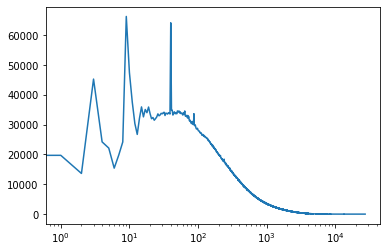

In [5]:
review_df.review_length.value_counts().sort_index().plot(logx=True)

In [4]:
review_df[review_df.review_length < 50].review_length.value_counts().sort_index()

0      6938
1     19717
2     13640
3     45288
4     24220
5     22144
6     15422
7     19845
8     24205
9     66297
10    47467
11    37583
12    30385
13    26734
14    32114
15    35955
16    32618
17    35097
18    34022
19    35913
20    33675
21    31992
22    32401
23    31484
24    32009
25    32592
26    33616
27    32977
28    33254
29    33810
30    33634
31    33967
32    34169
33    33071
34    33903
35    33726
36    33558
37    34014
38    33884
39    33581
40    64165
41    34872
42    34845
43    33229
44    33592
45    34321
46    34057
47    33651
48    33981
49    33656
Name: review_length, dtype: int64

The following steps check individual reviews for characteristics of non-reviews and create a derived review file with the identified non-reviews removed.


In [64]:
# helper is a module with simple helper functions
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException
from scripts.helper import read_csv
from collections import Counter
import re

def is_url(record):
    return record['review_length'] <= 40 and record['review_text'].startswith('http')
    
def is_rating(record):
    if record['review_length'] > 12:
        return False
    if record['review_length'] < 4 and re.search(r'\d', record['review_text']):
        return True
    for word in ['star', 'stars', 'sterne', 'ster', 'sterren', 'rating']:
        if re.search(word, record['review_text'], re.IGNORECASE) and re.search(r'\d', record['review_text']):
            return True
    return False

def is_date(record):
    if record['review_length'] > 12:
        return False
    if re.search(r'20\d{,2}', record['review_text']):
        return True
    return False

def is_empty(record):
    return record['review_length'] == 0

def is_non_review(record):
    if record['review_length'] > 40:
        return False
    return is_empty(record) or is_url(record) or is_rating(record) or is_date(record)

def lang_detect(record):
    try:
        return detect(record['review_text'])
    except LangDetectException:
        return 'unknown'

def is_english(record):
    return lang_detect == 'en'
    


In [37]:
review_filtered_file = os.path.join(data_dir, 'goodreads_reviews_dedup_filtered-no_text.csv.gz') # excludes text and non-reviews


headers = [
    'user_id', 'book_id', 'review_id', 'rating', 'date_added', 'date_updated', 'read_at', 
    'started_at', 'n_votes', 'n_comments', 'review_length', 'review_text'
]

with gzip.open(filtered_file, 'wt') as fh:
    writer = csv.writer(fh, delimiter='\t')
    writer.writerow(headers)
    for ri, record in enumerate(read_csv(review_text_file)):
        record['review_length'] = int(record['review_length'])
        if is_non_review(record):
            continue
        row = [record[header] for header in headers]
        writer.writerow(row)
        if (ri+1) % 1000000 == 0:
            print(ri+1, 'records parsed')

print(ri+1, 'records parsed')


/Volumes/Samsung_T5/Data/Book-Reviews/GoodReads/goodreads_reviews_dedup_filtered.csv.gz
1000000 records parsed
2000000 records parsed
3000000 records parsed
4000000 records parsed
5000000 records parsed
6000000 records parsed
7000000 records parsed
8000000 records parsed
9000000 records parsed
10000000 records parsed
11000000 records parsed
12000000 records parsed
13000000 records parsed
14000000 records parsed
15000000 records parsed
15739967 records parsed


In [3]:
# the filtered review file excludes text and non-reviews
review_filtered_file = os.path.join(data_dir, 'goodreads_reviews_dedup_filtered-no_text.csv.gz') 

review_df = pd.read_csv(review_filtered_file, sep='\t', compression='gzip')

review_df


,user_id,book_id,review_id,rating,date_added,date_updated,read_at,started_at,n_votes,n_comments,review_length
0,8842281e1d1347389f2ab93d60773d4d,24375664,5cd416f3efc3f944fce4ce2db2290d5e,5,Fri Aug 25 13:55:02 -0700 2017,Mon Oct 09 08:55:59 -0700 2017,Sat Oct 07 00:00:00 -0700 2017,Sat Aug 26 00:00:00 -0700 2017,16,0,968
1,8842281e1d1347389f2ab93d60773d4d,18245960,dfdbb7b0eb5a7e4c26d59a937e2e5feb,5,Sun Jul 30 07:44:10 -0700 2017,Wed Aug 30 00:00:26 -0700 2017,Sat Aug 26 12:05:52 -0700 2017,Tue Aug 15 13:23:18 -0700 2017,28,1,2086
2,8842281e1d1347389f2ab93d60773d4d,6392944,5e212a62bced17b4dbe41150e5bb9037,3,Mon Jul 24 02:48:17 -0700 2017,Sun Jul 30 09:28:03 -0700 2017,Tue Jul 25 00:00:00 -0700 2017,Mon Jul 24 00:00:00 -0700 2017,6,0,474
3,8842281e1d1347389f2ab93d60773d4d,22078596,fdd13cad0695656be99828cd75d6eb73,4,Mon Jul 24 02:33:09 -0700 2017,Sun Jul 30 10:23:54 -0700 2017,Sun Jul 30 15:42:05 -0700 2017,Tue Jul 25 00:00:00 -0700 2017,22,4,962
4,8842281e1d1347389f2ab93d60773d4d,6644782,bd0df91c9d918c0e433b9ab3a9a5c451,4,Mon Jul 24 02:28:14 -0700 2017,Thu Aug 24 00:07:20 -0700 2017,Sat Aug 05 00:00:00 -0700 2017,Sun Jul 30 00:00:00 -0700 2017,8,0,420
...,...,...,...,...,...,...,...,...,...,...,...
15616192,d0f6d1a4edcab80a6010cfcfeda4999f,1656001,b3d9a00405f7e96752d67b85deda4c7d,4,Mon Jun 04 18:08:44 -0700 2012,Tue Jun 26 18:58:46 -0700 2012,NaN,Sun Jun 10 00:00:00 -0700 2012,0,1,299
15616193,594c86711bd7acdaf655d102df52a9cb,10024429,2bcba3579aa1d728e664de293e16aacf,5,Fri Aug 01 18:46:18 -0700 2014,Fri Aug 01 18:47:07 -0700 2014,NaN,NaN,0,0,71
15616194,594c86711bd7acdaf655d102df52a9cb,6721437,7c1a7fcc2614a1a2a29213c11c991083,3,Tue Aug 27 12:49:25 -0700 2013,Tue Aug 27 12:53:46 -0700 2013,NaN,NaN,0,0,224
15616195,594c86711bd7acdaf655d102df52a9cb,15788197,74a9f9d1db09a90aae3a5acea68c6593,2,Fri May 03 13:06:15 -0700 2013,Fri May 03 15:35:39 -0700 2013,Fri May 03 15:35:39 -0700 2013,Fri May 03 00:00:00 -0700 2013,0,0,108


In [9]:
from dateutil.parser import parse, tz

def parse_date(date_str):
    try:
        return parse(date_str).astimezone(utc)
    except TypeError:
        return None

utc = tz.gettz('UTC')

#book_df = pd.read_csv(book_file, sep='\t', compression='gzip')

#book_df[['book_id', 'work_id']]
#review_df = pd.merge(review_df, book_df[['book_id', 'work_id']], on='book_id', how='left')

review_df['date_added'] = review_df.date_added.apply(parse_date)
review_df['date_updated'] = review_df.date_updated.apply(parse_date)
review_df['read_at'] = review_df.read_at.apply(parse_date)
review_df['started_at'] = review_df.started_at.apply(parse_date)

review_df.columns

Index(['user_id', 'book_id', 'review_id', 'rating', 'date_added',
       'date_updated', 'read_at', 'started_at', 'n_votes', 'n_comments',
       'review_length', 'work_id'],
      dtype='object')

In [10]:
review_df.to_csv(review_filtered_file, sep='\t', compression='gzip')

#review_df = pd.read_csv(review_filtered_file, sep='\t', compression='gzip')


### Making review subsets for content analysis

The entire Goodreads review collection including all the review text is too big to read into a dataframe, so we create a number of sample review subsets with text included that will be used for content analysis.

The following criteria will be used to analyse various aspects of scale:

- all reviews of frequently reviewed books (repetition across reviews as book characteristics)
- all reviews of frequent reviewers (repetition across reviews as reviewer characteristics)
- random sample of reviews (repetition across reviews as book review characteristics)


In [70]:
counts = review_df.book_id.value_counts()

threshold = 10000
books_above_10k = [book_id for book_id, count in counts[counts > threshold].iteritems()]
book_ids = list(book_df[book_df.book_id.isin(books_above_10k)].book_id)
work_ids = list(book_df[book_df.book_id.isin(books_above_10k)].work_id)
print(books_above_10k)
print(work_ids)
mapping = {str(book_id): work_id for book_id, work_id in zip(book_ids, work_ids)}
books_above_10k = [str(book_id) for book_id in books_above_10k]
print(f'number of books with over {threshold} reviews:', len(counts[counts > threshold]))
print(f'number of reviews for books with over {threshold} reviews:', sum(counts[counts > threshold]))

data_dir = '/Volumes/Samsung_T5/Data/Book-Reviews/GoodReads/'
sample_review_text_file = os.path.join(data_dir, 'goodreads_reviews-books_above_10k_reviews.csv.gz') # includes text

headers = [
    'user_id', 'book_id', 'work_id', 'review_id', 'rating', 'date_added', 'date_updated', 'read_at', 'started_at', 
    'n_votes', 'n_comments', 'review_length', 'review_lang', 'review_text', 'review_lang'
]

with gzip.open(sample_review_text_file, 'wt') as fh:
    writer = csv.writer(fh, delimiter='\t')
    writer.writerow(headers)
    for review in read_csv(review_text_file):
        if review['book_id'] not in books_above_10k:
            continue
        review['review_lang'] = lang_detect(review)
        review['work_id'] = mapping[review['book_id']]
        row = [review[header] for header in headers]
        writer.writerow(row)


[11870085, 2767052, 29056083, 20309175, 7260188, 22557272, 5470, 6148028, 19063, 10818853, 13335037, 41865]
[8812783, 15732562, 2792775, 3212258, 878368, 153313, 153313, 6171458, 41107568, 16827462, 48765776, 48765776, 28143699, 28143699, 28143699, 28143699, 28143699, 28143699, 28143699, 28143699, 28143699, 28143699, 28143699, 13155899]
number of books with over 10000 reviews: 12
number of reviews for books with over 10000 reviews: 167512


In [66]:
from scripts.helper import read_csv

counts = review_df.work_id.value_counts()

threshold = 10000
works_above_10k = [int(work_id) for work_id, count in counts[counts > threshold].iteritems()]
print(works_above_10k)
book_ids = set([str(book_id) for book_id in list(book_df[book_df.work_id.isin(works_above_10k)].book_id)])
work_ids = list(book_df[book_df.work_id.isin(works_above_10k)].work_id)
mapping = {str(book_id): work_id for book_id, work_id in zip(book_ids, work_ids)}

print(f'number of works with over {threshold} reviews:', len(counts[counts > threshold]))
print(f'number of reviews for works with over {threshold} reviews:', sum(counts[counts > threshold]))

data_dir = '/Volumes/Samsung_T5/Data/Book-Reviews/GoodReads/'
sample_review_text_file = os.path.join(data_dir, 'goodreads_reviews-works_above_10k_reviews.csv.gz') # includes text

headers = [
    'user_id', 'book_id', 'work_id', 'review_id', 'rating', 'date_added', 'date_updated', 'read_at', 'started_at', 
    'n_votes', 'n_comments', 'review_length', 'review_lang', 'review_text', 'review_lang'
]

with gzip.open(sample_review_text_file, 'wt') as fh:
    writer = csv.writer(fh, delimiter='\t')
    writer.writerow(headers)
    written = 0
    for ri, review in enumerate(read_csv(review_text_file)):
        if (ri+1) % 1000000 == 0:
            print(ri+1, 'reviews parsed', written, 'written')
        if review['book_id'] not in book_ids:
            continue
        review['review_lang'] = lang_detect(review)
        review['work_id'] = mapping[review['book_id']]
        written += 1
        row = [review[header] for header in headers]
        writer.writerow(row)
print(ri+1, 'reviews parsed', written, 'written')


[16827462, 48765776, 2792775, 28143699, 13306276, 13155899, 41107568, 8812783, 153313, 878368, 17763198, 6171458, 4640799, 15732562, 21825181, 15524549, 17225055, 14863741, 14345371, 3212258, 15545385, 2267189, 14245059, 15524542, 21861351, 4835472, 2754161, 3275794, 50459161]
{'17623911', '7623768', '17380203', '6469151', '848654', '13533423', '33229067', '634951', '1167751', '27069714', '25615225', '22919918', '6794926', '35478512', '20555501', '20661705', '18933600', '20792791', '23219487', '32678493', '31768151', '23211741', '18219043', '25459160', '24792411', '742573', '3708952', '13517276', '17225793', '22747979', '12783911', '31224712', '8045416', '7631356', '16071194', '24483350', '27281555', '10783858', '30652277', '16039145', '33285096', '35547598', '12658862', '21464429', '31333626', '30129222', '33638045', '6703256', '28421203', '17841055', '8376549', '22444974', '6565942', '16049993', '15780438', '2728527', '13541067', '7561318', '23562530', '30332792', '8146730', '1175483

100000 reviews parsed 2013 written
200000 reviews parsed 4103 written
300000 reviews parsed 6351 written
400000 reviews parsed 8555 written
500000 reviews parsed 10701 written
600000 reviews parsed 12692 written
700000 reviews parsed 14628 written
800000 reviews parsed 16675 written
900000 reviews parsed 18746 written
1000000 reviews parsed 20870 written
1100000 reviews parsed 22833 written
1200000 reviews parsed 24898 written
1300000 reviews parsed 26681 written
1400000 reviews parsed 28831 written
1500000 reviews parsed 30908 written
1600000 reviews parsed 32997 written
1700000 reviews parsed 35007 written
1800000 reviews parsed 36898 written
1900000 reviews parsed 38950 written
2000000 reviews parsed 40817 written
2100000 reviews parsed 42744 written
2200000 reviews parsed 44942 written
2300000 reviews parsed 47112 written
2400000 reviews parsed 49475 written
2500000 reviews parsed 51626 written
2600000 reviews parsed 53931 written
2700000 reviews parsed 55797 written
2800000 review

In [77]:
counts[counts > threshold]

print(len(book_ids), len(work_ids), len(mapping.keys()))
review_df.columns

0 0 0


Index(['user_id', 'book_id', 'review_id', 'rating', 'date_added',
       'date_updated', 'read_at', 'started_at', 'n_votes', 'n_comments',
       'review_length', 'work_id'],
      dtype='object')

In [88]:
counts = review_df.user_id.value_counts()

threshold = 5000
users_above_5k = [user_id for user_id, count in counts[counts > threshold].iteritems()]
book_ids = list(review_df[review_df.user_id.isin(users_above_5k)].book_id)
work_ids = list(review_df[review_df.user_id.isin(users_above_5k)].work_id)
print(users_above_5k)
print(len(book_ids))
print(len(work_ids))
mapping = {str(book_id): work_id for book_id, work_id in zip(book_ids, work_ids)}
print(f'number of users with over {threshold} reviews:', len(counts[counts > threshold]))
print(f'number of reviews for users with over {threshold} reviews:', sum(counts[counts > threshold]))

data_dir = '/Volumes/Samsung_T5/Data/Book-Reviews/GoodReads/'
sample_review_text_file = os.path.join(data_dir, 'goodreads_reviews-reviewers_above_5k_reviews.csv.gz') # includes text

headers = [
    'user_id', 'book_id', 'work_id', 'review_id', 'rating', 'date_added', 'date_updated', 'read_at', 'started_at', 
    'n_votes', 'n_comments', 'review_length', 'review_lang', 'review_text', 'review_lang'
]


with gzip.open(sample_review_text_file, 'wt') as fh:
    writer = csv.writer(fh, delimiter='\t')
    writer.writerow(headers)
    written = 0
    for ri, review in enumerate(read_csv(review_text_file)):
        if (ri+1) % 100000 == 0:
            print(ri+1, 'reviews parsed', written, 'written')
        if review['user_id'] not in users_above_5k:
            continue
        try:
            review['work_id'] = mapping[review['book_id']]
        except KeyError:
            continue
        written += 1
        review['review_lang'] = lang_detect(review)
        row = [review[header] for header in headers]
        writer.writerow(row)
print(ri+1, 'reviews parsed', written, 'written')


['a2d6dd1685e5aa0a72c9410f8f55e056', '459a6c4decf925aedd08e45045c0d8c6', '4922591667fd3e8adc0c5e3d42cf557a', 'dd9785b14664103617304996541ed77a', '843a44e2499ba9362b47a089b0b0ce75', '9003d274774f4c47e62f77600b08ac1d', 'b7772313835ce6257a3fbe7ad2649a29', '8bb031b637de69eba020a8a466d1110b', '8e7e5b546a63cb9add8431ee6914cf59', '6ac35fe952c608da50153d64f616291b', '795595616d3dbd81bd16b617c9a1fa48', 'a45fb5d39a6a9857ff8362900790510a', '60982541be85a0611e9634b4f63d0cb0', '97e2ce2141fa1c880967d78aec3c14fa', '422e76592e2717d5d59465d22d74d47c', '59151b639f247aa97fffd5c71701db29', 'e5905d648022af7b1309d82a1f4d255b', '37b3e60b4e4152c580fd798d405150ff', 'd8c39b3b11bb2da1c1d5c39f49669dea']
148355
148355
number of users with over 5000 reviews: 19
number of reviews for users with over 5000 reviews: 148355
100000 reviews parsed 3848 written
200000 reviews parsed 3848 written
300000 reviews parsed 3848 written
400000 reviews parsed 9192 written
500000 reviews parsed 9192 written
600000 reviews parsed 91

,user_id,book_id,review_id,rating,date_added,date_updated,read_at,started_at,n_votes,n_comments,review_length,work_id


In [56]:
data_dir = '/Volumes/Samsung_T5/Data/Book-Reviews/GoodReads/'
sample_review_text_file = os.path.join(data_dir, 'goodreads_reviews-random_sample_1M.csv.gz') # includes text

headers = [
    'user_id', 'book_id', 'work_id', 'review_id', 'rating', 'date_added', 'date_updated', 'read_at', 'started_at', 
    'n_votes', 'n_comments', 'review_length', 'review_lang', 'review_text', 'review_lang'
]

threshold = 1000000
prob_threshold = threshold / len(review_df)

with gzip.open(sample_review_text_file, 'wt') as fh:
    writer = csv.writer(fh, delimiter='\t')
    writer.writerow(headers)
    for review in read_csv(review_text_file):
        if np.random.rand() > prob_threshold:
            continue
        review['review_lang'] = lang_detect(review)
        row = [review[header] for header in headers]
        writer.writerow(row)
